<a href="https://colab.research.google.com/github/anikch/Image-denoising-using-convolutional-autoencoder/blob/main/Generating_images_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import numpy as np
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU

# Loading and checking data

In [2]:
# Loading MNIST dataset
mnist = tf.keras.datasets.mnist 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
# Data Exploration
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


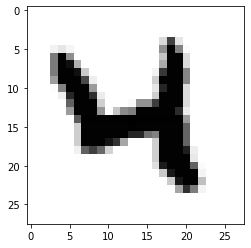

In [4]:
# Checking a random image
plt.imshow(X_train[20,:,:], cmap='gray_r')

# Data Preprocessing

In [5]:
# Changing data type and reshaping
X_train= X_train.astype('float32').reshape(-1, 28,28,1)
X_test= X_test.astype('float32').reshape(-1, 28,28,1)

# Normalizing date [-1 to 1]
X_train= (X_train - 127.5) / 127.5

# Model Building

In [6]:
# parameters
latent_dim= 100
img_inp= (28,28,1)

In [7]:
# Generator architecture
def generator_model(latent_dim):
  model= tf.keras.Sequential()
  n_nodes= 128 * 7 * 7
  model.add(tf.keras.layers.Dense(n_nodes, use_bias= False, input_dim= latent_dim))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(0.2))
  model.add(tf.keras.layers.Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), use_bias= False, strides= (2, 2), padding= 'same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), use_bias= False, strides= (2, 2), padding= 'same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(0.2))
  model.add(tf.keras.layers.Conv2D(1, (7, 7), activation= 'tanh', padding= 'same'))
  return model

In [8]:
# Discriminator architecture
def discriminator_model(inp= img_inp):
	model= tf.keras.Sequential()
	model.add(tf.keras.layers.Conv2D(64, (3,3), strides= (2, 2), padding= 'same', input_shape= inp))
	model.add(LeakyReLU(0.2))
	model.add(tf.keras.layers.Dropout(0.5))
	model.add(tf.keras.layers.Conv2D(64, (3,3), strides= (2, 2), padding= 'same'))
	model.add(LeakyReLU(0.2))
	model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
	opt= tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)
	model.compile(loss= 'binary_crossentropy', optimizer= opt, metrics= ['accuracy'])
	return model

In [9]:
# Discriminator model
discriminator= discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [10]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt= tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)
	model.compile(loss='binary_crossentropy', optimizer= opt)
	return model

In [11]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


  # use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [12]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [14]:
# create the discriminator
d_model = discriminator_model()
# create the generator
g_model = generator_model(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = X_train
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79, 155/234, d=0.683, g=0.710
>79, 156/234, d=0.684, g=0.706
>79, 157/234, d=0.696, g=0.678
>79, 158/234, d=0.683, g=0.663
>79, 159/234, d=0.698, g=0.697
>79, 160/234, d=0.688, g=0.722
>79, 161/234, d=0.688, g=0.731
>79, 162/234, d=0.684, g=0.713
>79, 163/234, d=0.699, g=0.714
>79, 164/234, d=0.680, g=0.692
>79, 165/234, d=0.696, g=0.693
>79, 166/234, d=0.683, g=0.700
>79, 167/234, d=0.688, g=0.692
>79, 168/234, d=0.690, g=0.697
>79, 169/234, d=0.699, g=0.707
>79, 170/234, d=0.688, g=0.705
>79, 171/234, d=0.698, g=0.696
>79, 172/234, d=0.691, g=0.698
>79, 173/234, d=0.700, g=0.695
>79, 174/234, d=0.692, g=0.703
>79, 175/234, d=0.683, g=0.721
>79, 176/234, d=0.688, g=0.707
>79, 177/234, d=0.696, g=0.700
>79, 178/234, d=0.686, g=0.698
>79, 179/234, d=0.690, g=0.681
>79, 180/234, d=0.684, g=0.698
>79, 181/234, d=0.682, g=0.724
>79, 182/234, d=0.692, g=0.717
>79, 183/234, d=0.683, g=0.715
>79, 184/234, d=0.694, g=0.687
>79, 185/234, d=0.7

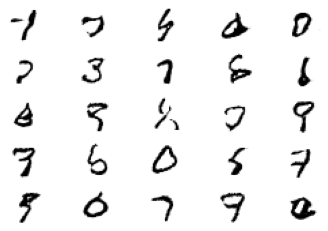

In [22]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
 
# load model
model = tf.keras.models.load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

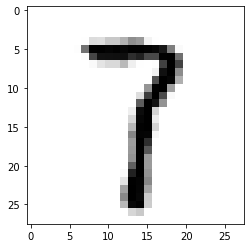

In [29]:
# Generating single image
# load model
model = load_model('generator_model_100.h5')
# creating different vectors from latent space
vector1= asarray([[1 for _ in range(100)]])
vector2= asarray([[-1 for _ in range(100)]])
# generate image
X = model.predict(vector2)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()